In [35]:
import importlib
import warnings
from collections import defaultdict
import altair as alt
from ipywidgets import Video
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

warnings.filterwarnings('ignore')

def get_data():
    import pandas as pd
    data = []
    mn, mx = float("+inf"), float("-inf")

    for k, arr in loss_tracker.items():
        for i, v in enumerate(arr):
            data.append(dict(model=k, metric='loss', loss=v, epoch=i))
            mn = min(v, mn)
            mx = max(v, mx)
    return pd.DataFrame(data), mn, mx

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [37]:
import taranis
import torch

loss_tracker = defaultdict(list)

# Machine Learning Primer



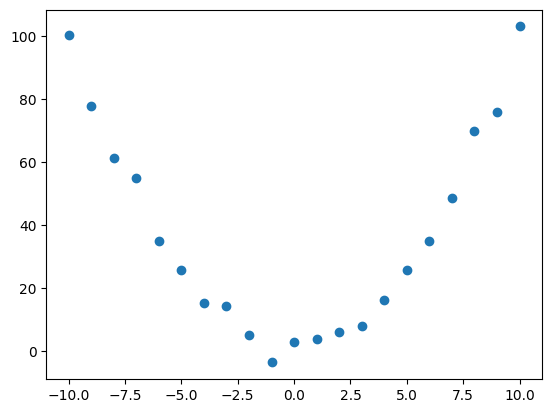

In [38]:
eps = np.random.normal(0, 3, 21)
x = np.asarray(list(range(-10, 11)))
y = x ** 2 + eps

plt.scatter(x, y)

 Linear regression does not work for non linear data

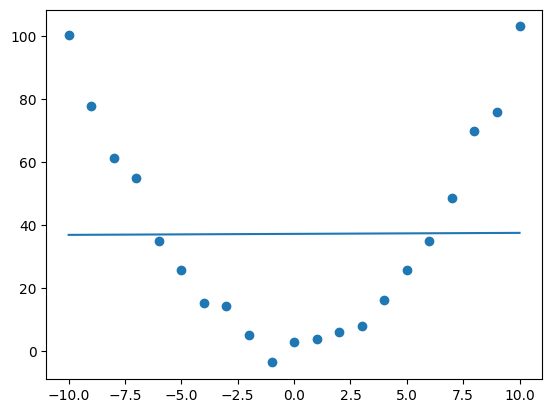

In [39]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x]
plt.scatter(x, y)
plt.plot(x, pred)

If we know the non linearity we can linearize the relationship
by applying it, the resulting problem becomes linear again

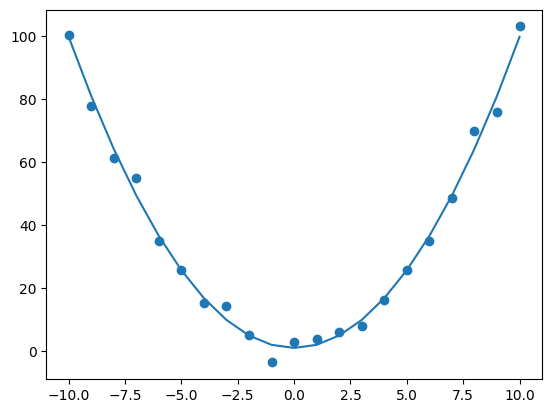

In [40]:
reg = LinearRegression().fit((x ** 2).reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x ** 2]
plt.scatter(x, y)
plt.plot(x, pred)

The problem is: there is an infinity of non linearities and the data can get pretty complex for find non linearity by ourself is not an option. Thankfully Neural Network can approximate any functions and thus learn the non linearity for us.

# Making a Linear Regression in Pytorch

In [41]:
model = nn.Sequential(
    nn.Linear(1, 1),      # 1 Input 1 output : a * x + b
)

In [42]:
def to_tensor(v):
    return torch.tensor(v, dtype=torch.float).unsqueeze(1)


def to_array(v):
    return v.detach().numpy()

##  Generate data

In [43]:
x = np.asarray(list(range(-10, 11)))
y = x ** 2

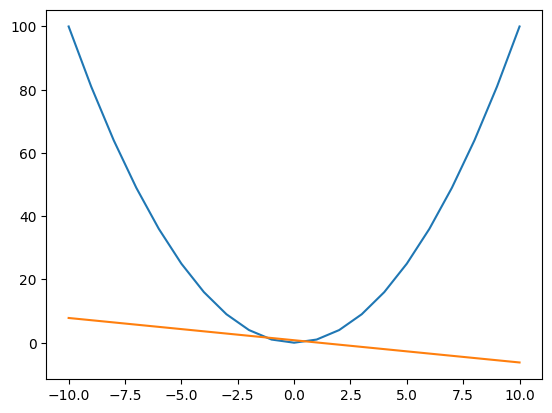

In [44]:
def show_model_estimate(model, x, y):    
    pred = to_array(model(to_tensor(x)))

    plt.plot(x, y)
    plt.plot(x, pred)
    
show_model_estimate(model, x, y)

2373.82958984375
1416.0369873046875
1070.8658447265625
1068.274169921875
1068.2926025390625
1068.310791015625
1068.3291015625
1068.347412109375
1068.3658447265625
1068.3841552734375


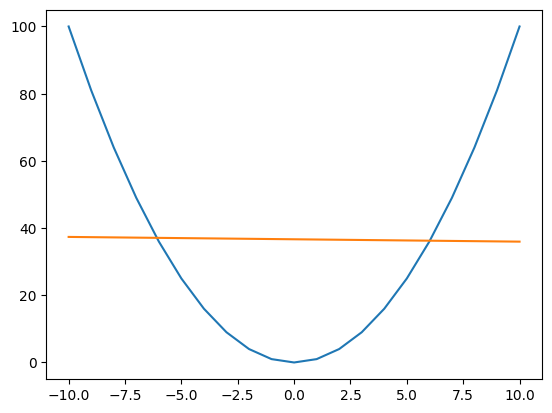

In [45]:
def train_reg(model, x, y, epoch=100, lr=1):
    optimizer = optim.Adadelta(model.parameters(), lr=1)

    for i in range(epoch):
        
        optimizer.zero_grad()                  # Clear derivative
        
        pred = model(to_tensor(x))             # Make Prediction
         
        loss = F.mse_loss(pred, to_tensor(y))  # Grade prediction
        
        loss.backward()                        # Compute derivative
        
        optimizer.step()                       # Update weights

        if i % (epoch / 10) == 0:
            print(loss.item())
            

train_reg(model, x, y, 20000)
show_model_estimate(model, x, y)

# Making Non Linear Regression

## Making the Model deeper ?

In [46]:
model = nn.Sequential(
    nn.Linear(1, 100),      #  o1  = x * w1 + b1     x: (N x 1) w1: (1 x 100)  b1: (1 x 100) o1: (N x 100)
    nn.Linear(100, 30),     #  o2 = o1 * w2 + b2                w2: (100 x 30) b2: (1 x  30) o2: (N x 30)
    nn.Linear(30, 1)        #  o3 = o2 * w3 + b3                w3: (30 x 1)   b3: (1 x 1)   
)
 
#  o3 = ((x * w1 + b1) * w2 + b2) * w3 + b3
#  o3 = (x * w1 + b1) * w2 * w3  + b2 * w3  + b3
#  o3 = x * w1* w2 * w3  + b1 * w2 * w3  + b2 * w3 + b3

# W = w1 * w2 * w3
# B = b1 * w2 * w3  + b2 * w3 + b3

# o3 = x * W + B
# STILL LINEAR

2416.955322265625
1080.3653564453125
1084.0064697265625
1080.1915283203125
1084.0947265625
1083.8232421875
1082.9544677734375
1079.66552734375
1078.728271484375
1076.6026611328125


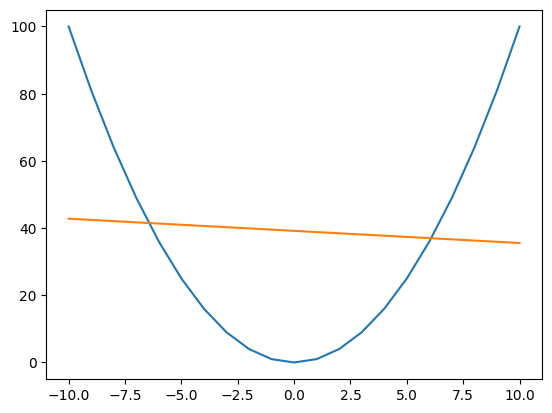

In [47]:
train_reg(model, x, y, 1000, lr=0.001)
show_model_estimate(model, x, y)

# Break linearity with a non linear activation function

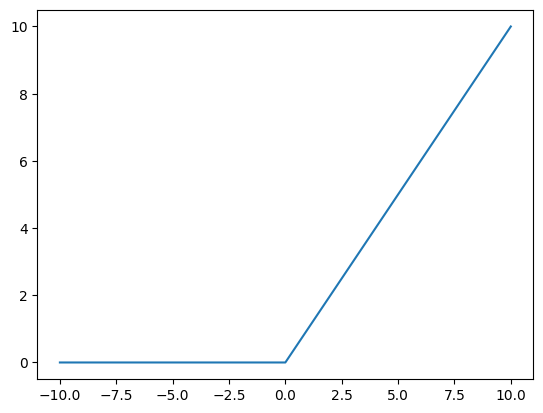

In [50]:
relu_result = to_array(nn.ReLU()(to_tensor(x)))

plt.plot(x, relu_result)

In [51]:
model = nn.Sequential(
    nn.Linear(1, 2),   # o1 = x * w1 + b1        #  o1 = [x * w11 + b11, x * w12 + b12]
    nn.ReLU(),         # o2 = max(o1, 0)         #  o2 = [max(x * w11 + b11, 0), max(x * w12 + b12, 0)]
    nn.Linear(2, 1),   # o3 = o2 * w2 + b2       #  o3 = max(x * w11 + b11, 0) * w21 + max(x * w12 + b12, 0) * w22 + b2
)

# The estimator is now non linear
# o3 = max(x * w1 + b1, 0) * w2 + b2 

# Without matrices
#
# o3 = max(x * w11 + b11, 0) * w21 + max(x * w12 + b12, 0) * w22 + b2
#     |--------------------------|  |--------------------------|
#      First Linear Approximation    Second Linear Approximation
#
#
#  We are learning a piecewise approximation of our function
#  piecewise linear is still non linear and we can get as close as we want by
#  increasing the number of neurons.
#
#  https://en.wikipedia.org/wiki/Piecewise_linear_function


2495.1201171875
2146.717529296875
1388.3477783203125
295.9853515625
187.34637451171875
160.60792541503906
138.3338165283203
115.92568969726562
89.03083801269531
61.73624801635742


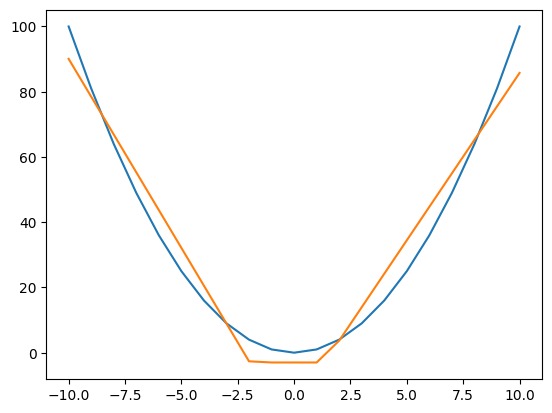

In [52]:
x = np.asarray(list(range(-10, 11)))
y = x ** 2

train_reg(model, x, y, 1000, lr=1)
show_model_estimate(model, x, y)

2356.857177734375
2053.42529296875
1575.7982177734375
1306.203369140625
1258.5306396484375
1231.74365234375
1202.1146240234375
1158.6409912109375
1113.2283935546875
1095.8150634765625


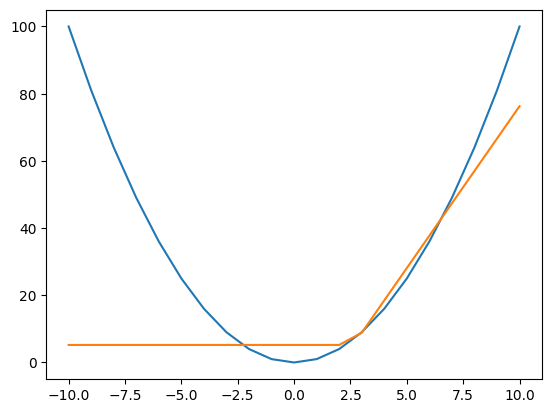

In [53]:
model = nn.Sequential(
    nn.Linear(1, 2),   # o1 = x * w1 + b1        #  o1 = [x * w11 + b11, x * w12 + b12]
    nn.ReLU(),         # o2 = max(o1, 0)         #  o2 = [max(x * w11 + b11, 0), max(x * w12 + b12, 0)]
    nn.Linear(2, 1),   # o3 = o2 * w2 + b2       #  o3 = max(x * w11 + b11, 0) * w21 + max(x * w12 + b12, 0) * w22 + b2
)

# The estimator is now non linear
# o3 = max(x * w1 + b1, 0) * w2 + b2 

train_reg(model, x, y, 1000, lr=1)
show_model_estimate(model, x, y)

2504.66162109375
1597.128662109375
1264.6036376953125
197.9178924560547
152.9188995361328
115.16561889648438
73.7217788696289
39.941375732421875
27.070980072021484
25.055370330810547


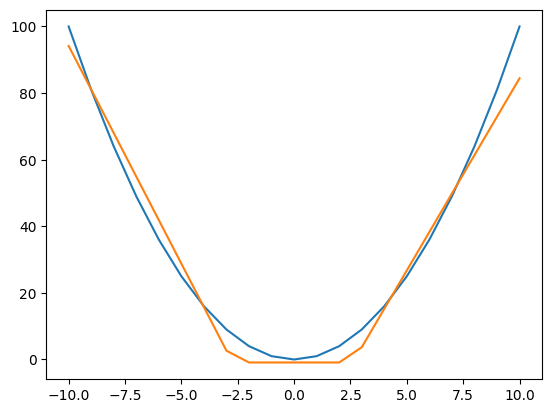

In [54]:
model = nn.Sequential(
    nn.Linear(1, 2),   # o1 = x * w1 + b1        #  o1 = [x * w11 + b11, x * w12 + b12]
    nn.ReLU(),         # o2 = max(o1, 0)         #  o2 = [max(x * w11 + b11, 0), max(x * w12 + b12, 0)]
    nn.Linear(2, 1),   # o3 = o2 * w2 + b2       #  o3 = max(x * w11 + b11, 0) * w21 + max(x * w12 + b12, 0) * w22 + b2
)

# The estimator is now non linear
# o3 = max(x * w1 + b1, 0) * w2 + b2 

train_reg(model, x, y, 1000, lr=1)
show_model_estimate(model, x, y)

# Increase number of neurons to reduce randomness

2357.60791015625
72.89095306396484
40.01155090332031
29.360652923583984
23.869054794311523
20.058792114257812
16.576847076416016
14.307689666748047
12.345142364501953
10.921928405761719


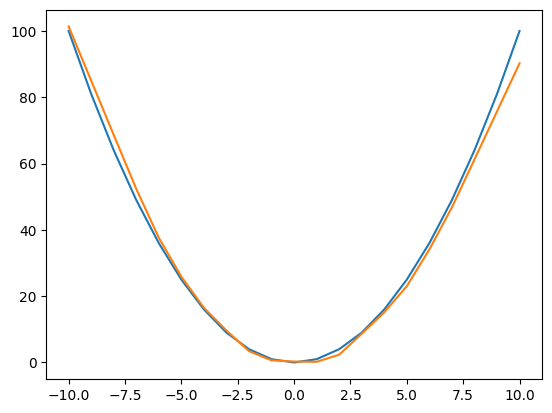

In [55]:
model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)

train_reg(model, x, y, 2000)
show_model_estimate(model, x, y)

# Non Linear correlation

Cor matrix:
 [[ 1.00000000e+00 -2.73542223e-17]
 [-2.73542223e-17  1.00000000e+00]]
--


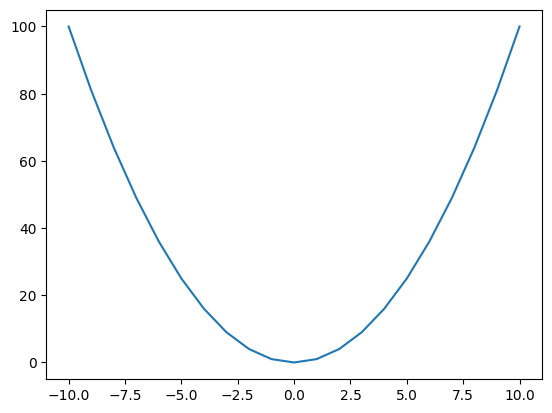

In [222]:
# Regular linear Correlation does not work well shows x, y are essentially not correlated
print('Cor matrix:\n', np.corrcoef(x, y))
print('--')
plt.plot(x, y)

[[1.         0.99565371]
 [0.99565371 1.        ]]


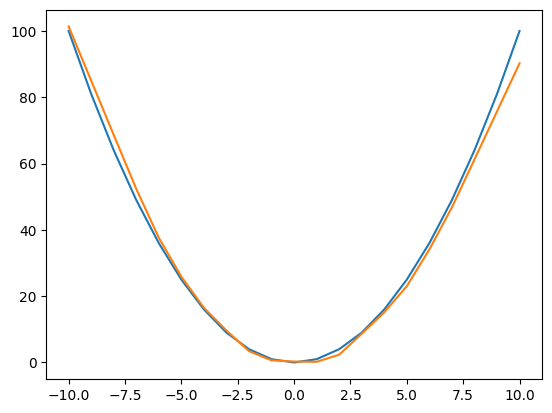

In [56]:
pred = model(to_tensor(x)).detach().squeeze().numpy()

#
# Correlation is essentially one
#
print(np.corrcoef(pred, y))

plt.plot(x, y)
plt.plot(x, pred)

# Generalization

Current models are not able to learn or infer outside of the training set
if we increase the domain of the function from $[-10, 10]$ we can see that the error will keep increasing.

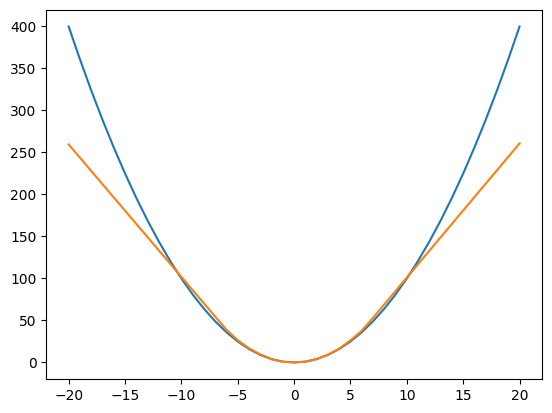

In [166]:
x = np.asarray(list(range(-20, 21)))
y = x ** 2

i# nput = torch.tensor(x, dtype=torch.float).unsqueeze(1)
# pred = model(input).detach().numpy()

show_model_estimate(model, x, y)

# With sin the issue is more obvious

0.4071817100048065
0.02220546454191208
0.016087686643004417
0.011918433010578156
0.00893999170511961
0.006933975499123335
0.005485565401613712
0.004464928526431322
0.0037370750214904547
0.0032157283276319504


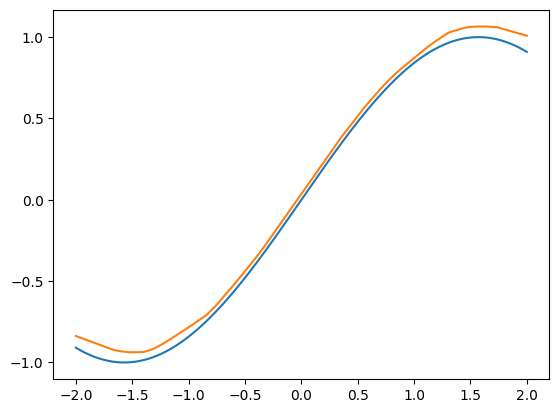

In [57]:
x = np.asarray(list(range(-100, 101))) / 50
y = np.sin(x)

model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)

train_reg(model, x, y, 2000)

show_model_estimate(model, x, y)

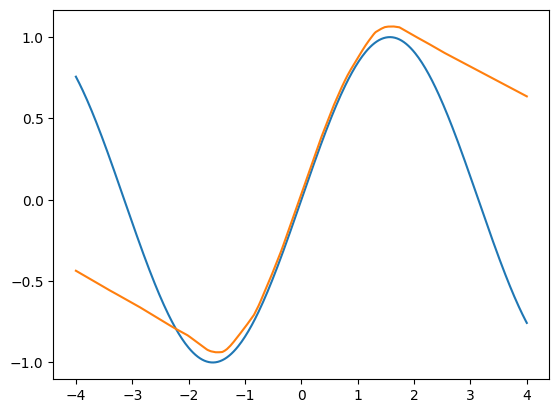

In [58]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

show_model_estimate(model, x, y)

0.5795333385467529
0.15871278941631317
0.05555283650755882
0.03044070117175579
0.027268655598163605
0.0316898375749588
0.0361194908618927
0.03748008608818054
0.03692452982068062
0.035665325820446014


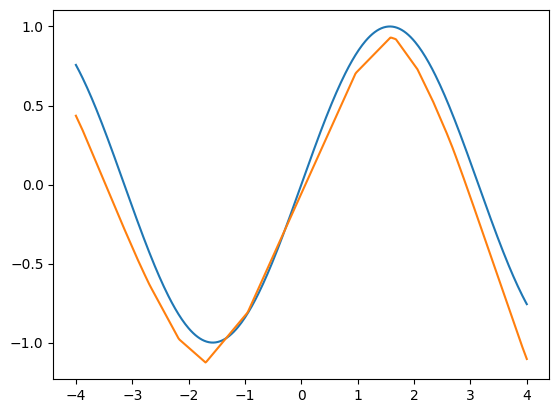

In [60]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

model = nn.Sequential(
    nn.Linear(1, 512),  
    nn.ReLU(),             
    nn.Linear(512, 1), 
)

train_reg(model, x, y, 4000)

show_model_estimate(model, x, y)

# Vision introduction

## Dataset

In [61]:
from torchvision import datasets
from torchvision import transforms

In [62]:
dataset = datasets.MNIST(
    '../data', 
    train=True, 
    download=True
)
print(len(dataset))

60000


In [63]:
image, label = dataset[0]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

(28, 28) 5


In [64]:
image, label = dataset[1]
image

In [65]:
image, label = dataset[2]
image

Machine learning is all about creating a function `f` that will learn to approximate a function
For classification we want to approximate a function that will recognize the image it has been given in input

$ f(image) -> class\{ 0-9 \}$

## Linear Regression

## Model definition

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F


n_class = 10


# x                 : N x 28 x 28
# x = Flatten(x)    : N x 728
# x = Linear(x)     : N x 10      = (N x 728) * (728 x 10) + 1 x 10 
# x = Softmax(x)    : N x 10      


linear = nn.Sequential(
    nn.Flatten(),                  # Flatten images from a 2D matrix to 1D => (28x28) => (784,)
    nn.LazyLinear(n_class),        # Simple (a x + b) layer that will learn `a` and `b`
    nn.Softmax(dim=1)              # Normalization so result wil be between [0, 1]
)

In [67]:
# https://www.3blue1brown.com/lessons/neural-networks
Video.from_file("pixels-to-neurons.mp4")

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

## Prepare Images for the model

In [68]:
image, label = dataset[2]
batch = transforms.ToTensor()(image) # Transform an image to a tensor/matrix

print(image)
print(batch.shape)

<PIL.Image.Image image mode=L size=28x28 at 0x22A5F3E1A60>
torch.Size([1, 28, 28])


## Make predictions

Of course the model has not been trained yet so the result below are trash.

In [69]:
result = linear(batch)
print('Result:  ', result.shape)

Result:   torch.Size([1, 10])


## Read Predictions

In [70]:
print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction: `', prediction.item(), '` Truth: `', label, '`')


Confidence of the image to be:
  - 0:  8.80
  - 1: 10.44
  - 2: 10.24
  - 3: 10.89
  - 4:  9.20
  - 5: 12.77
  - 6:  9.18
  - 7:  8.31
  - 8:  9.43
  - 9: 10.74

Prediction: ` 5 ` Truth: ` 4 `


# Training

In [71]:
import torch.optim as optim
import torch
import taranis.core.dataset.split as split
from taranis.core.trainer.train import mnist_dataset
from tqdm import tqdm

NOTE: Redirects are currently not supported in Windows or MacOs.


## Dataloading

In [73]:
def newdataloader(batch_size=512):
    # Takes the original dataset and apply transform on the fly
    # Convert image to a tensor
    # normalize the tensor
    dataset_to_use = split.TransformedDatasetClassification(
        dataset, 
        transform=transforms.Compose([                    
            transforms.ToTensor(),                         # Transform the image to tensor
            transforms.Normalize((0.1307,), (0.3081,)),    # Normalize the image
        ])
    )

    # Takes care of spliting the dataset into bite size for our model
    dataloader = torch.utils.data.DataLoader(
        dataset_to_use,
        batch_size = batch_size,
        num_workers = 1,
    )
    
    return dataloader

## Optimizer

In [74]:
def train(name, model, epoch=2, lr=0.4):
    batch_size = 512
    dataloader = newdataloader(batch_size)
    
    model = model.cpu()

    # Gradient optimizer 
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    losses = loss_tracker[name]
    
    with tqdm(total=len(dataset) * epoch, ncols=100) as progress:

        # Repeat a few times 
        for i in range(epoch):
            total_loss = 0
            count = 0

            # Go through the dataset
            for batch, labels in dataloader:
    
                optimizer.zero_grad()                     # Clear previous derivative

                probabilities = model(batch)              # Make prediction

                loss = F.nll_loss(probabilities, labels)  # Grade the prediction 

                loss.backward()                           # Compute derivative

                optimizer.step()                          # Update parameters using derivative

                total_loss += loss.item()                 # Keep track of loss to make sure it goes down

                count += 1
                
                progress.update(batch_size)
            
            loss = total_loss / count
            losses.append(loss)
            progress.set_description(f"loss: {loss:8.4f}")
    
    return losses

# Train

In [75]:
train('linear', linear, lr=1, epoch=2)

loss:  -0.8834: : 120832it [00:19, 6165.49it/s]                                                     


[-0.7873660155524642, -0.883433876401287]

## Prediction

In [76]:
image, label = dataset[2]
batch = transforms.ToTensor()(image)

image

In [77]:
result = linear(batch)
print('Result:  ', result.shape)

print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction', prediction.item(), 'Truth:', label)
image

Result:   torch.Size([1, 10])

Confidence of the image to be:
  - 0:  3.37
  - 1:  0.80
  - 2:  5.23
  - 3: 17.27
  - 4: 48.44
  - 5:  1.18
  - 6:  3.90
  - 7:  1.31
  - 8:  7.04
  - 9: 11.46

Prediction 4 Truth: 4


# Non Linearity

Model is linear only so it can only approximate linear relationships
what is we create more layers ?

In [78]:
deepmodel_bad = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),    # r1 =  
    nn.LazyLinear(64),     # r2 = (x * a1 + b1) * a2 + b2
    nn.LazyLinear(10),     # r3 = x * w + b
    nn.Softmax(dim=1)      #    w = a1 * a2* a3
                           #    b = b1 * a2* a3 + b2* a3  + b3
)

# r3 = r2 * w3 + b3
# r3 = (r1 * w2 + b2) * w3 + b3
# r3 = r1 * w2 * w3 + b2 * w3  + b3
# r3 = (batch * w1 + b1) * w2 * w3 + b2 * w3  + b3
# r3 = batch * w1 * w2 * w3 + b1 * w2 * w3 + b2 * w3  + b3
#
# r3 = batch * w + b
#  w = w1 * w2 * w3 + b1
#  b =  b1 * w2 * w3 + b2 * w3  + b3
#
#
#   MODEL is still LINEAR
#

batch = transforms.ToTensor()(image)
result = deepmodel_bad(batch)
result.shape

train('deepmodel_bad', deepmodel_bad, lr=1, epoch=2)

loss:  -0.8993: : 120832it [00:19, 6095.01it/s]                                                     


[-0.7904603351223267, -0.8993310731346325]

## Breaking Linearity

In [79]:
#
# Adding non linear function between 
#
deepmodel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),    # r1 = batch * w1 + b1
    nn.ReLU(),             # r2 = max(r1, 0)
    nn.LazyLinear(64),     # r3 = r3 * w3 + b3
    nn.ReLU(),             # r4 = max(r3, 0)
    nn.LazyLinear(10),     # r5 = r4 * w4 + b4
    nn.Softmax(dim=1)  
)

#
# Layers cannot be factorized anymore
#
batch = transforms.ToTensor()(image)
result = deepmodel(batch)

# How does training work ?
train('deepmodel', deepmodel, lr=1, epoch=2)

loss:  -0.8987: : 120832it [00:19, 6069.01it/s]                                                     


[-0.660351796359834, -0.898662623712572]

# Mesuring network's precision

In [80]:
def test_model(model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST('../data', train=False,  transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=4096, num_workers=1) 
    
    total = len(dataset)
    model = model.cpu()
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        
        for batch, labels in loader:
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item()  
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()

        print(f'Accuracy {correct / total * 100:.2f} {100 - correct / total * 100:.2f}')

In [81]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)

Accuracy 91.03 8.97
Accuracy 89.65 10.35
Accuracy 91.36 8.64


In [82]:
train('linear',        linear       , lr=1  , epoch=5)
train('deepmodel_bad', deepmodel_bad, lr=1  , epoch=5)
train('deepmodel',     deepmodel    , lr=1  , epoch=5)

loss:  -0.9131: : 302080it [00:50, 5967.44it/s]                                                     
loss:  -0.9229: : 302080it [00:49, 6099.24it/s]                                                     
loss:  -0.9586: : 302080it [00:49, 6118.27it/s]                                                     


[-0.660351796359834,
 -0.898662623712572,
 -0.9256118677430234,
 -0.9386855767945111,
 -0.946948533341036,
 -0.9532261253413508,
 -0.9585546118728185]

In [83]:
def show_loss_curve():
    data, mn, mx = get_data()
    return (
        alt.Chart(data)
        .mark_line()
        .encode(
            x=alt.X('epoch'), 
            y=alt.Y("loss", scale=alt.Scale(domain=[mn, mx])), 
            color=alt.Color(
                'model', 
                legend=alt.Legend(
                orient='none',
                legendX=130, legendY=-40,
                direction='horizontal',
                titleAnchor='middle')
            )
        )
    )

show_loss_curve()

alt.Chart(...)

In [84]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)

Accuracy 92.21 7.79
Accuracy 91.92 8.08
Accuracy 95.93 4.07


Linear model plateau quickly.
Deeper model can learn more but take longer to train.

# Going faster with GPU

In [85]:
from functools import cache

@cache
def newdataloader_cuda(batch_size=512, train=True):
    dataset_to_use = mnist_dataset(train)
    dataset_to_use.tensors = list(dataset_to_use.tensors)
    for i, t in enumerate(dataset_to_use.tensors):
        dataset_to_use.tensors[i] = t.cuda()

    # Takes care of spliting the dataset into bite size for our model
    dataloader = torch.utils.data.DataLoader(
        dataset_to_use,
        batch_size = batch_size,
        num_workers = 0,
    )
    
    return dataloader


def gpu_train(name, original_model, epoch=2, lr=0.4, batch_size=4096):
    dataloader = newdataloader_cuda(batch_size)        # HERE optimized loader
    device = torch.cuda.current_device()               # HERE Get GPU device
    model = original_model.to(device)                  # HERE Convert model to GPU
    
    optimizer = optim.Adadelta(model.parameters(), lr=1)
    losses = loss_tracker[name]
    
    with tqdm(total=len(dataset) * epoch, ncols=100) as progress:
        for i in range(epoch):
            partial_losses = []
            count = 0
            for batch, labels in dataloader:
                batch, labels = batch.to(device), labels.to(device) # HERE: Convert input to GPU

                optimizer.zero_grad()

                probabilities = model(batch)

                loss = F.nll_loss(probabilities, labels)

                loss.backward()

                optimizer.step()

                partial_losses.append(loss.detach())
                count += 1
                
                progress.update(batch_size)

            total_loss = (sum(partial_losses) / count).item()
            losses.append(total_loss)
            progress.set_description(f"loss: {total_loss:8.4f}")
    
    return losses
    
def gpu_test_model(model, batch_size=4096*2):
    dataloader = newdataloader_cuda(batch_size, train=False)     # HERE optimized loader
    total = len(dataloader.dataset)
    
    device = torch.cuda.current_device()  # HERE
    model = model.to(device=device)       # HERE
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total_count = 0
        
        for batch, labels in dataloader:
            batch, labels = batch.to(device), labels.to(device) # HERE
            
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item() 
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total_count += batch.shape[0]

        assert total_count == total, f"{total_count} != {total}"
        print('Accuracy', correct / total * 100, 100 - correct / total * 100)

In [86]:
gpu_train('linear'       , linear       , lr=0.5, epoch=5)
gpu_train('deepmodel_bad', deepmodel_bad, lr=0.5, epoch=5)
gpu_train('deepmodel'    , deepmodel    , lr=0.5, epoch=5)

loss:  -0.9177: : 307200it [00:05, 61169.37it/s]                                                    
loss:  -0.9313: : 307200it [00:02, 114563.74it/s]                                                   
loss:  -0.9679: : 307200it [00:02, 107388.62it/s]                                                   


[-0.660351796359834,
 -0.898662623712572,
 -0.9256118677430234,
 -0.9386855767945111,
 -0.946948533341036,
 -0.9532261253413508,
 -0.9585546118728185,
 -0.964372992515564,
 -0.9656522274017334,
 -0.9664937257766724,
 -0.9672268629074097,
 -0.9679062366485596]

In [87]:
show_loss_curve()

alt.Chart(...)

In [88]:
gpu_test_model(linear       )
gpu_test_model(deepmodel_bad)
gpu_test_model(deepmodel    )

Accuracy 92.63 7.3700000000000045
Accuracy 92.52 7.480000000000004
Accuracy 96.32 3.680000000000007


In [89]:
def trainfast(*args, **kwargs):
    if torch.cuda.is_available():
        return gpu_train(*args, **kwargs)
    return train(*args, **kwargs)

def testfast(*args, **kwargs):
    if torch.cuda.is_available():
        return gpu_test_model(*args, **kwargs)
    return test_model(*args, **kwargs)

# Different Layers

Linear layers are quite resource intensive often we will use specialized layer for some specific data.
For example, images will often use convolution layers.

Convolution apply a filter on an image and produce another image https://fr.wikipedia.org/wiki/Noyau_(traitement_d%27image)

In [90]:
Video.from_file("convolution.webm")

Video(value=b'\x1aE\xdf\xa3\x9fB\x86\x81\x01B\xf7\x81\x01B\xf2\x81\x04B\xf3\x81\x08B\x82\x84webmB\x87\x81\x02B…

In [91]:
image, label = dataset[2]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

(28, 28) 4


In [92]:
conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
print(conv.weight.shape)

batch = transforms.ToTensor()(image)
print(batch.shape)
result = conv(batch)
print(result.shape)

torch.Size([32, 1, 3, 3])
torch.Size([1, 28, 28])
torch.Size([32, 26, 26])


Example of images generated from a convolution

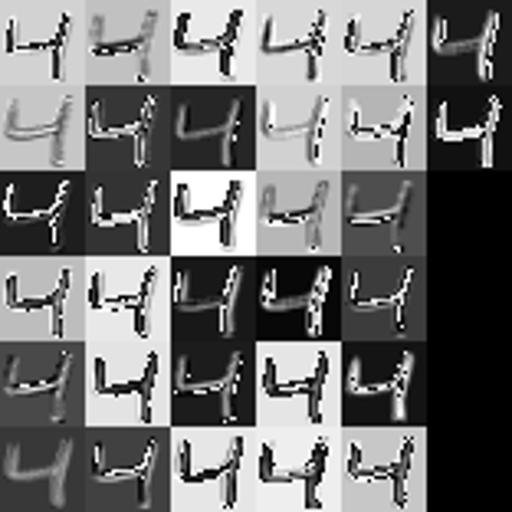

In [93]:
import taranis.core.visualization as viz 
transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512))

# New network with a convolution layer

From a single image it is going to learn to generate 32 new ones to better classify them

In [94]:
from torch.nn import init
from torch import Tensor
import math

import taranis.core.nn as ext_nn
        
conv_model = nn.Sequential(
    # ext_nn.MaskLayer((28, 28)),
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(576 * 64, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1),
)

batch = transforms.ToTensor()(image).unsqueeze(0)
batch = torch.concat([batch, batch])
conv_model(batch).shape

torch.Size([2, 10])

## Training

In [ ]:
trainfast('conv_model', conv_model, lr=1, epoch=2)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=1, epoch=5)
trainfast('conv_model', conv_model, lr=0.5, epoch=5)

loss:  -0.5662: : 122880it [00:31, 3896.44it/s]                                                     
loss:  -0.8428: : 307200it [01:13, 4205.07it/s]                                                     
loss:  -0.8682: : 307200it [01:12, 4258.50it/s]                                                     
loss:  -0.8807: : 307200it [01:13, 4202.27it/s]                                                     
loss:  -0.8838: : 307200it [00:59, 6717.73it/s]                                                     

## Compare

In [ ]:
show_loss_curve()

In [ ]:
testfast(linear)
testfast(deepmodel_bad)
testfast(deepmodel)
testfast(conv_model)

## Inspect learned Convolution Kernels

In [ ]:
conv_model = conv_model.cpu()

for i in range(4):
    image, label = dataset[i]
    conv = list(conv_model.children())[0]

    batch = transforms.ToTensor()(image)
    result = conv(batch)
    print(result.shape)
    plt.imshow(transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512)), cmap='Greys')
    plt.show()

In [ ]:
importlib.reload(viz)
viz.show_steps(conv_model, dataset)